# Capstone Project : Sign Language Recognition


In [ ]:
!rm -rf "sample_data"

In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from shutil import copyfile
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.12.0


## Download and Inspect the Dataset

upload your kaggle token

In [ ]:
from google.colab import files

print("upload your kaggle token [ kaggle.json ]\n")
uploaded = files.upload()

upload your kaggle token [ kaggle.json ]



Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d mlanangafkaar/datasets-lemlitbang-sibi-alphabets

100% 1.75G/1.75G [00:22<00:00, 66.6MB/s]
100% 1.75G/1.75G [00:22<00:00, 83.3MB/s]


extract dataset to /tmp

In [ ]:
from zipfile import ZipFile

zip_ref = zipfile.ZipFile('./datasets-lemlitbang-sibi-alphabets.zip', 'r')
zip_ref.extractall('/tmp/datasets-lemlitbang-sibi-alphabets')
zip_ref.close()

In [ ]:
# Move dataset raw dataset to /content/SIBI_RAW
!mv /tmp/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/ /content/SIBI_RAW

# Deletes all non-image files from dataset
!find /content/SIBI_RAW -type f ! -name "*.jpg" -exec rm {} +


In [ ]:
def plot_image(file_location):
  img = load_img(file_location)
  img_arr = img_to_array(img)

  print(f"file ini memiliki shape {img_arr.shape}\n")
  img = mpimg.imread(file_location)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

file ini memiliki shape (2000, 2000, 3)



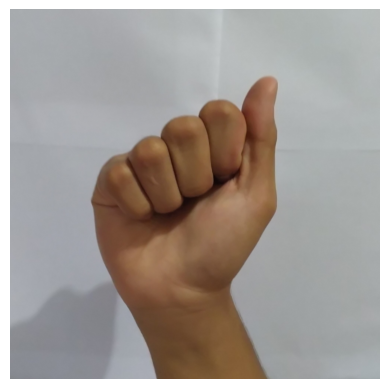

In [ ]:
plot_image('./SIBI_RAW/training/A/A_1.jpg')

## Creating the generators for the CNN

In [ ]:
# DEFINE FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator( rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='sparse',
                                                      target_size=(300, 300))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(300, 300))

  return train_generator, validation_generator

In [ ]:
TRAINING_DIR = "/content/SIBI_RAW/training/"
VALIDATION_DIR = "/content/SIBI_RAW/validation/"

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 468 images belonging to 26 classes.
Found 52 images belonging to 26 classes.


## Coding the CNN

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  # Define the correct function signature for on_epoch_end
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.99:
      print("\nReached 99% accuracy so cancelling training!")
      # Stop training once the above condition is met
      self.model.stop_training = True

In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
  ])

  # Set the training parameters
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Get the untrained model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
# Train the model, this may take some time.
callbacks = myCallback()

history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/100
24/24 [==============================] - 93s 4s/step - loss: 3.2625 - accuracy: 0.0449 - val_loss: 3.2281 - val_accuracy: 0.1154
Epoch 2/100
24/24 [==============================] - 82s 3s/step - loss: 2.7617 - accuracy: 0.1944 - val_loss: 2.2108 - val_accuracy: 0.3077
Epoch 3/100
24/24 [==============================] - 80s 3s/step - loss: 1.4523 - accuracy: 0.5598 - val_loss: 1.4267 - val_accuracy: 0.5769
Epoch 4/100
24/24 [==============================] - 78s 3s/step - loss: 0.7380 - accuracy: 0.7671 - val_loss: 1.2339 - val_accuracy: 0.6538
Epoch 5/100
24/24 [==============================] - 83s 3s/step - loss: 0.3168 - accuracy: 0.8974 - val_loss: 1.1882 - val_accuracy: 0.6923
Epoch 6/100
24/24 [==============================] - 78s 3s/step - loss: 0.1858 - accuracy: 0.9487 - val_loss: 1.0631 - val_accuracy: 0.7885
Epoch 7/100
24/24 [==============================] - 77s 3s/step - loss: 0.1484 - accuracy: 0.9637 - val_loss: 1.0270 - val_accuracy: 0.7692
Epoch 8/100
2

In [ ]:
def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'], c='r')
  plt.plot(history.history['val_accuracy'], c='b')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'], c='r')
  plt.plot(history.history['val_loss'], c='b')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

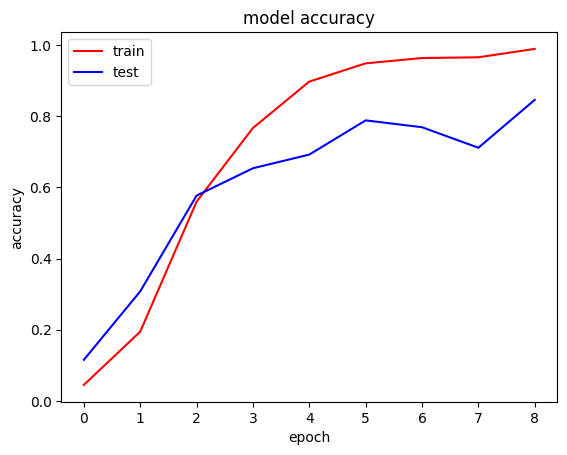

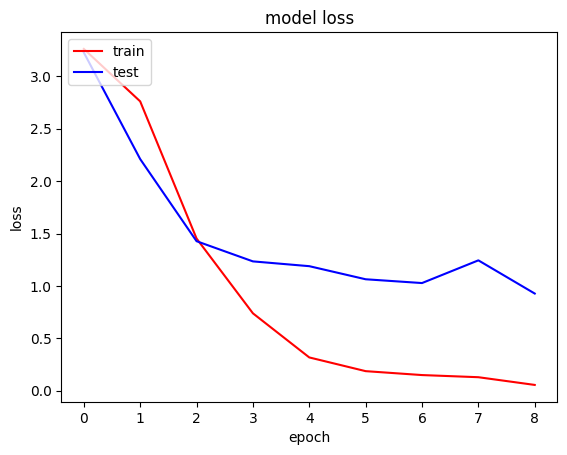

In [ ]:
plot_history(history)

## Testing

Testing with upload File

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving 1685528721964.jpg to 1685528721964.jpg
1/1 [==============================] - 0s 184ms/step
1685528721964.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


testing from local file

In [ ]:
path = '/content/SIBI_RAW/test/S (3).jpg'
img = load_img(path, target_size=(300, 300))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(fn)
print(classes)

1/1 [==============================] - 0s 48ms/step
1685528721964.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


## Save History and Model

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

In [ ]:
model.save('my_model.h5')
files.download('my_model.h5')